In [1]:
from hdbcli import dbapi
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pyplot

from functools import reduce

from datetime import datetime
import datetime

pd.set_option('display.max_columns', None)

load_dotenv()

False

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
#from featurewiz import featurewiz
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Part 1 - Read in the data

In [3]:
mod=pd.read_csv('gs://ebill_enrollment_model/input_20250626/model_sample2.csv')
val=pd.read_csv('gs://ebill_enrollment_model/input_20250811/validation_20250811.csv')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
print(mod.shape)
print(val.shape)

In [ ]:
failure_samp=pd.concat([mod.assign(seg='mod'), val.assign(seg='val')])

In [8]:
del mod, val

In [9]:
def trans_df(df):
    df['create_ca_sub_ct_360'].fillna(0, inplace=True)
    df['invceZcreate_ca_ct_360d'].fillna(0, inplace=True)
    df['pymtZpymt_ca_ct_360d'].fillna(-100, inplace=True)
    df['lockZfica_intr_ca_ct_360d'].fillna(-2, inplace=True)
    df['inplZcreate_ca_ct_180d'].fillna(-1, inplace=True)
    df['lockZcact_dunn_ca_ct_180d'].fillna(-1, inplace=True)
    df['lockZfica_post_ca_ct_180d'].fillna(-1, inplace=True)
    df['acct_age'].fillna(1000, inplace=True)
    df['pymt_ca_am_360d'].fillna(-100, inplace=True)
    df['pymtZpymt_ca_recency'].fillna(-1, inplace=True)
    df['count_HB_90'].fillna(-1, inplace=True)
    df['pymt_ca_sub_am_30'].fillna(-50, inplace=True)
    df['recency_S1'].fillna(0, inplace=True)
    df['invce_ca_am_90d'].fillna(5000, inplace=True)
    df['count_ML_180'].fillna(-5, inplace=True)
    df['count_AM_180'].fillna(-10, inplace=True)
    df['count_DP_360'].fillna(-10, inplace=True)
    df['count_S1_30'].fillna(1, inplace=True)
    
    df['lock_ca_ct_360d']=np.where(df['lock_ca_ct_360d'].isnull()==True, 0, 
                                   np.where(df['lock_ca_ct_360d'] > 12, 12, df['lock_ca_ct_360d']))
    df['fica_intr_ca_sub_ct_360']=np.where(df['fica_intr_ca_sub_ct_360'].isnull()==True, 0, 
                                           np.where(df['fica_intr_ca_sub_ct_360'] > 12, 12, df['fica_intr_ca_sub_ct_360']))
    
    df['create_ca_sub_am_360'].fillna(-2000, inplace=True)


    df['cact_cnt']=np.where(df['cact_cnt'].isnull()==True, 0, 
                            np.where(df['cact_cnt'] > 2, 2, df['cact_cnt']))
    df['cact_intr_ca_sub_recency']=np.where(df['cact_intr_ca_sub_recency'].isnull()==True, 0, 
                                            np.where(df['cact_intr_ca_sub_recency'] > 158, 158, df['cact_intr_ca_sub_recency']))
    df['count_F1_360'].fillna(-1, inplace=True)
    df['recency_IN'].fillna(0, inplace=True)
    df['count_W1_360'].fillna(-1, inplace=True)
    df['recency_J5'].fillna(0, inplace=True)
    df['count_RF_360'].fillna(-1, inplace=True)

    df['recency_I1']=np.where(df['recency_I1'].isnull()==True, 0, 1)
    df['count_ED_360'].fillna(-1, inplace=True)
    df['count_IB_360'].fillna(1, inplace=True)
    df['count_MP_360'].fillna(1, inplace=True)
    df['count_CP_360'].fillna(-1, inplace=True)
    df['count_CS_360'].fillna(-1, inplace=True)
    
    # newly added for Snowflake data
    df['lockZcact_intr_ca_recency'].fillna(-10, inplace=True)
    df['cact_intr_ca_sub_ct_30'].fillna(1, inplace=True)
    df['last_payment_recency'].fillna(-200, inplace=True)
    df['cact_intr_ca_sub_recency'].fillna(0, inplace=True)
    df['invceZcreate_ca_ct_30d'].fillna(-1, inplace=True)
    df['invce_ca_ct_30d'].fillna(-1, inplace=True)
    df['collprop_ca_sub_recency']=np.where(df['collprop_ca_sub_recency'].isnull()==True, 0,
                                           np.where( df['collprop_ca_sub_recency'] > 10, 10, 
                                                     df['collprop_ca_sub_recency']))
    
    df['pred_ca_recency']=np.where(df['pred_ca_recency'].isnull()==True, 0,
                                   np.where( df['pred_ca_recency'] > 10, 10, 
                                            df['pred_ca_recency']))
    df['pcomm_ca_recency'].fillna(0, inplace=True)
    df['lock_ca_recency'].fillna(0, inplace=True)
    df['invceZcreate_ca_recency'].fillna(0, inplace=True)
    df['ip_amp_paymentdue_ca_sub_am_180'].fillna(-10, inplace=True)
    df['lockZcact_dunn_ca_recency'].fillna(-10, inplace=True)
    df['cact_dunn_ca_sub_recency'].fillna(0, inplace=True)
    df['ip_amp_paymentdue_ca_sub_recency'].fillna(0, inplace=True)
    df['inpl_ca_am_60d']=np.where(df['inpl_ca_am_60d'].isnull()==True, -5, 
                                  np.where(df['inpl_ca_am_60d'] > 0, 1, 0))
    df['inpl_ca_recency'].fillna(0, inplace=True)
    df['create_ca_sub_recency'].fillna(0, inplace=True)
    df['lockZfica_intr_ca_recency'].fillna(0, inplace=True)
    df['odfc_due_reminder_ca_sub_recency'].fillna(0, inplace=True)
    
    
trans_df(failure_samp)

/var/tmp/ipykernel_26045/4037667106.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['create_ca_sub_ct_360'].fillna(0, inplace=True)
/var/tmp/ipykernel_26045/4037667106.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [10]:
xlist=['create_ca_sub_ct_360','invceZcreate_ca_ct_360d','pymtZpymt_ca_ct_360d',
'lockZfica_intr_ca_ct_360d','inplZcreate_ca_ct_180d','lockZcact_dunn_ca_ct_180d',
'lockZfica_post_ca_ct_180d','acct_age','pymt_ca_am_360d','pymtZpymt_ca_recency',
'count_HB_90','pymt_ca_sub_am_30','recency_S1','invce_ca_am_90d','count_ML_180',
'count_AM_180','count_DP_360','count_S1_30','cact_cnt','cact_intr_ca_sub_recency',
#'count_F1_360',
       'recency_IN','count_W1_360','recency_J5','count_RF_360',
#'recency_I1',
'count_ED_360','count_IB_360','count_MP_360', 'count_CP_360','count_CS_360']

/var/tmp/ipykernel_26045/41899399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xlist2['y']=failure_samp['y']


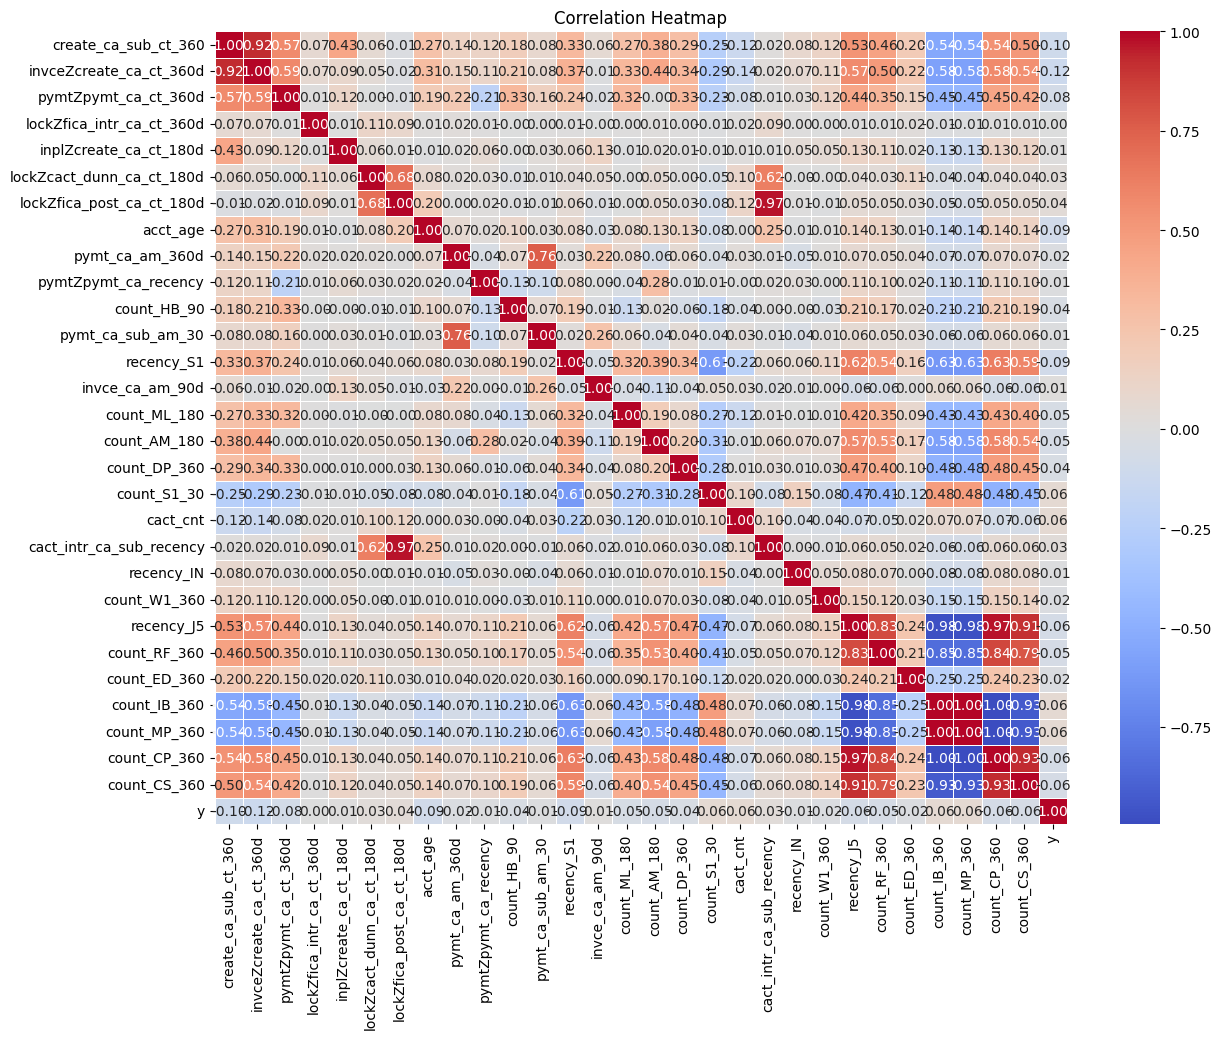

In [11]:
xlist2=failure_samp[xlist]
xlist2['y']=failure_samp['y']

correlation_matrix=xlist2.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(13, 10.5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

21


/var/tmp/ipykernel_26045/3533153438.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xlist2['y']=failure_samp['y']


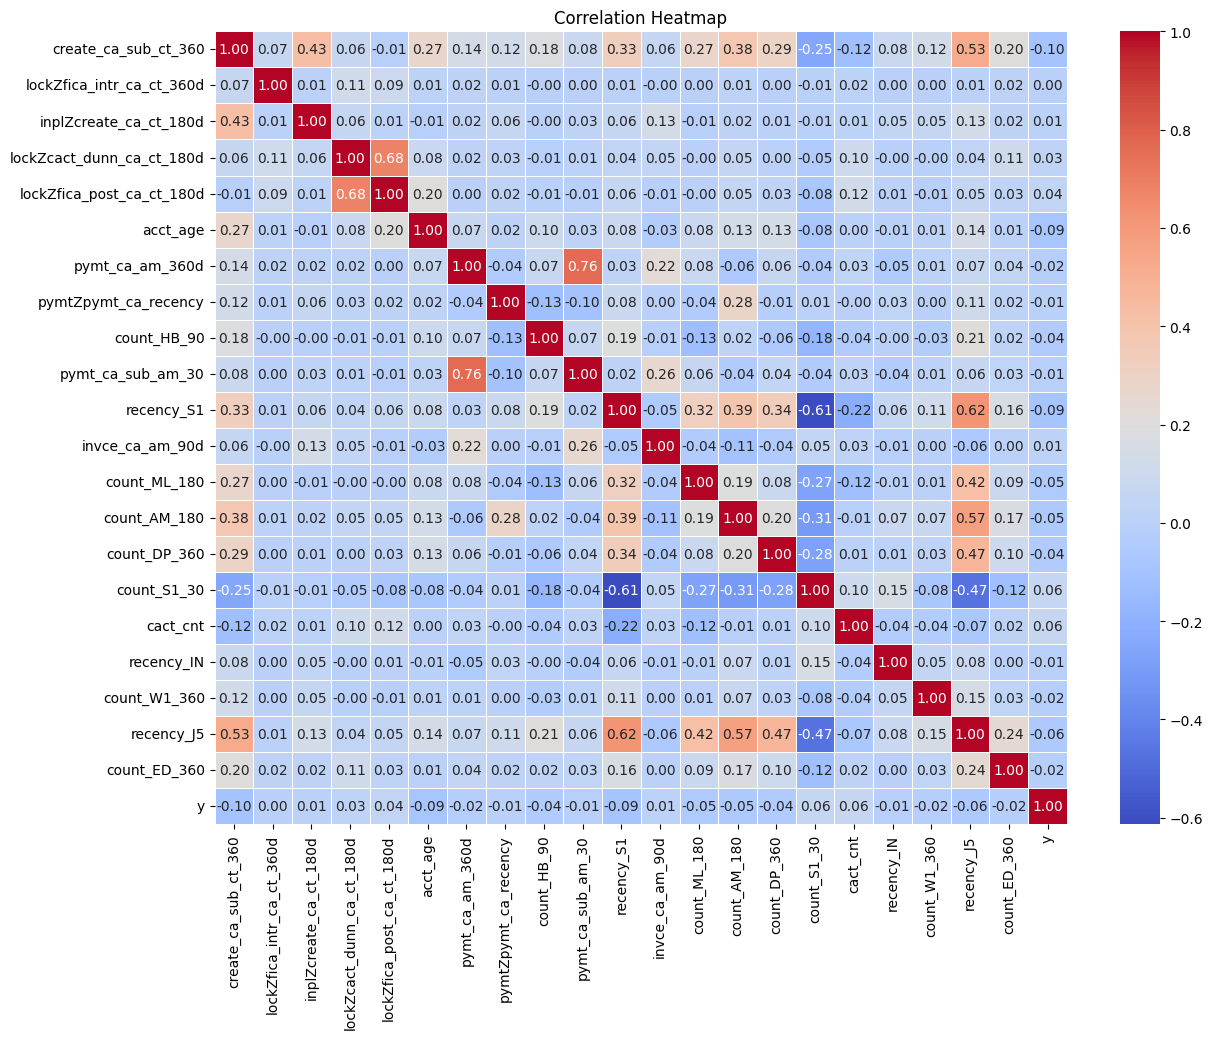

In [12]:
# remove columns with very high collreation
xlist=['create_ca_sub_ct_360',
       #'invceZcreate_ca_ct_360d','pymtZpymt_ca_ct_360d',
'lockZfica_intr_ca_ct_360d','inplZcreate_ca_ct_180d','lockZcact_dunn_ca_ct_180d',
'lockZfica_post_ca_ct_180d','acct_age','pymt_ca_am_360d','pymtZpymt_ca_recency',
'count_HB_90','pymt_ca_sub_am_30','recency_S1','invce_ca_am_90d','count_ML_180',
'count_AM_180','count_DP_360','count_S1_30','cact_cnt',
       #'cact_intr_ca_sub_recency',
# 'count_F1_360',  # no longer available as of 8/25
       'recency_IN','count_W1_360','recency_J5',
       #'count_RF_360','recency_I1',
'count_ED_360',
       #'count_IB_360',
       #'count_MP_360', 'count_CP_360',
       #'count_CS_360'
      ]
print(len(xlist))
xlist2=failure_samp[xlist]
xlist2['y']=failure_samp['y']

correlation_matrix=xlist2.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(13, 10.5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

In [13]:
del xlist2

19


/var/tmp/ipykernel_26045/4268692754.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xlist2['y']=failure_samp['y']


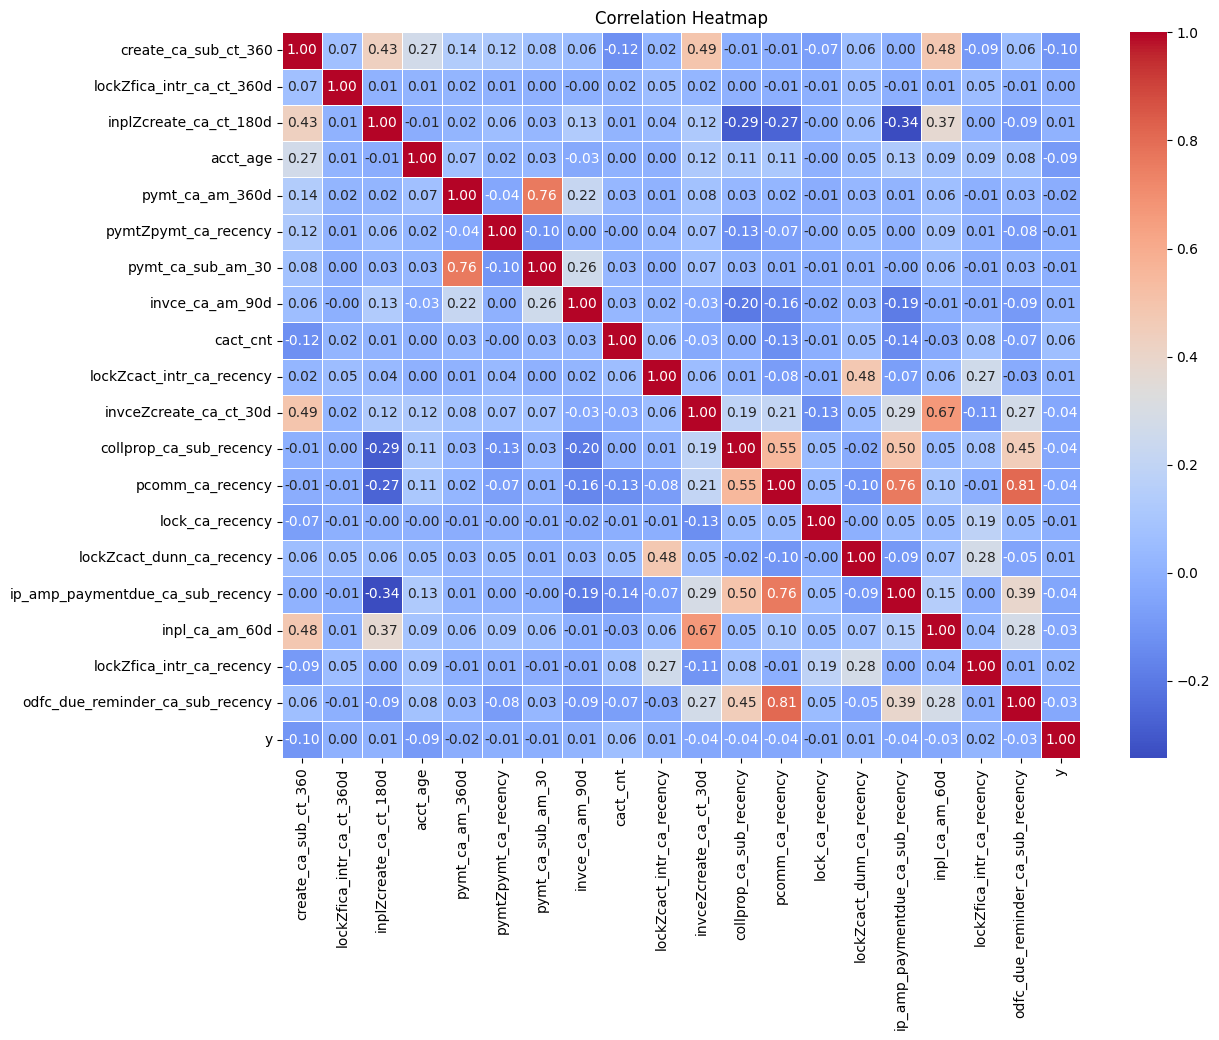

In [14]:
# removing all SAP variables
xlist=['create_ca_sub_ct_360',
       #'invceZcreate_ca_ct_360d','pymtZpymt_ca_ct_360d',
'lockZfica_intr_ca_ct_360d', 'inplZcreate_ca_ct_180d', 
       #'lockZcact_dunn_ca_ct_180d','lockZfica_post_ca_ct_180d',  # no importance
       'acct_age','pymt_ca_am_360d','pymtZpymt_ca_recency',
#'count_HB_90',
       'pymt_ca_sub_am_30',
       #'recency_S1',
       'invce_ca_am_90d',
       #'count_ML_180',
#'count_AM_180','count_DP_360','count_S1_30',
       'cact_cnt',
       #'cact_intr_ca_sub_recency',
# 'count_F1_360',  # no longer available as of 8/25
      # 'recency_IN','count_W1_360','recency_J5',
       #'count_RF_360','recency_I1',
#'count_ED_360',
       #'count_IB_360',
       #'count_MP_360', 'count_CP_360',
       #'count_CS_360'
'lockZcact_intr_ca_recency', 
       #'cact_intr_ca_sub_ct_30', 
       #'last_payment_recency',
       #'cact_intr_ca_sub_recency',
       'invceZcreate_ca_ct_30d',
       # 'invce_ca_ct_30d',  # no importance
       'collprop_ca_sub_recency', 
       # 'pred_ca_recency'  # perfect correlation with previous
       'pcomm_ca_recency', 'lock_ca_recency', 
       # 'invceZcreate_ca_recency','ip_amp_paymentdue_ca_sub_am_180', # no importance
       'lockZcact_dunn_ca_recency', 
       #'cact_dunn_ca_sub_recency', 
       'ip_amp_paymentdue_ca_sub_recency',
       'inpl_ca_am_60d', 
       #'inpl_ca_recency', 
       #'create_ca_sub_recency',  # no importance
       'lockZfica_intr_ca_recency', 'odfc_due_reminder_ca_sub_recency'
]
print(len(xlist))
xlist2=failure_samp[xlist]
xlist2['y']=failure_samp['y']

correlation_matrix=xlist2.corr()


# Create a heatmap using seaborn
plt.figure(figsize=(13, 10.5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

In [15]:
failure_samp[xlist].describe()

,create_ca_sub_ct_360,lockZfica_intr_ca_ct_360d,inplZcreate_ca_ct_180d,acct_age,pymt_ca_am_360d,pymtZpymt_ca_recency,pymt_ca_sub_am_30,invce_ca_am_90d,cact_cnt,lockZcact_intr_ca_recency,invceZcreate_ca_ct_30d,collprop_ca_sub_recency,pcomm_ca_recency,lock_ca_recency,lockZcact_dunn_ca_recency,ip_amp_paymentdue_ca_sub_recency,inpl_ca_am_60d,lockZfica_intr_ca_recency,odfc_due_reminder_ca_sub_recency
count,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06,2.991765e+06
mean,1.112724e+01,4.824067e+00,1.647522e-01,1.030191e+03,1.664710e+03,2.906657e+01,1.483746e+02,8.700515e+02,5.330566e-01,6.974799e+00,9.729979e-01,8.192283e+00,5.073016e+02,1.750838e+01,4.032060e+00,5.447406e+02,7.116535e-03,5.147931e+00,5.376712e+02
std,3.384985e+00,1.077566e+02,9.203180e-01,2.470919e+02,3.837015e+03,4.414951e+01,4.717372e+02,5.515537e+03,6.848803e-01,5.589286e+01,3.383685e-01,3.581461e+00,2.005381e+02,3.175686e+01,4.584123e+01,1.624789e+02,6.810579e-01,1.212132e+01,1.672590e+02
min,0.000000e+00,-2.000000e+00,-1.000000e+00,1.000000e+00,-6.300030e+03,-1.000000e+00,-5.000000e+01,-1.196926e+06,0.000000e+00,-1.000000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+01,0.000000e+00,-5.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,-2.000000e+00,0.000000e+00,1.000000e+03,4.863200e+02,7.000000e+00,0.000000e+00,1.358400e+02,0.000000e+00,-1.000000e+01,1.000000e+00,1.000000e+01,6.000000e+02,7.000000e+00,-1.000000e+01,6.000000e+02,0.000000e+00,0.000000e+00,6.000000e+02
50%,1.200000e+01,-2.000000e+00,0.000000e+00,1.000000e+03,1.171360e+03,1.800000e+01,8.140000e+01,3.525000e+02,0.000000e+00,-1.000000e+01,1.000000e+00,1.000000e+01,6.000000e+02,1.500000e+01,-1.000000e+01,6.000000e+02,0.000000e+00,0.000000e+00,6.000000e+02
75%,1.200000e+01,1.200000e+01,0.000000e+00,1.000000e+03,2.188720e+03,3.000000e+01,1.922000e+02,7.732300e+02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+01,6.000000e+02,2.300000e+01,0.000000e+00,6.000000e+02,0.000000e+00,7.000000e+00,6.000000e+02
max,2.800000e+02,1.808200e+05,1.170000e+02,2.155000e+03,1.283192e+06,3.650000e+02,2.123064e+05,5.079254e+06,2.000000e+00,3.650000e+02,2.000000e+01,1.000000e+01,6.000000e+02,6.000000e+02,3.650000e+02,6.000000e+02,1.000000e+00,3.650000e+02,6.000000e+02


In [16]:
failure_samp[xlist].isnull().sum()

create_ca_sub_ct_360                0
lockZfica_intr_ca_ct_360d           0
inplZcreate_ca_ct_180d              0
acct_age                            0
pymt_ca_am_360d                     0
pymtZpymt_ca_recency                0
pymt_ca_sub_am_30                   0
invce_ca_am_90d                     0
cact_cnt                            0
lockZcact_intr_ca_recency           0
invceZcreate_ca_ct_30d              0
collprop_ca_sub_recency             0
pcomm_ca_recency                    0
lock_ca_recency                     0
lockZcact_dunn_ca_recency           0
ip_amp_paymentdue_ca_sub_recency    0
inpl_ca_am_60d                      0
lockZfica_intr_ca_recency           0
odfc_due_reminder_ca_sub_recency    0
dtype: int64

In [17]:
failure_samp.groupby('seg').size()

seg
mod    1000217
val    1991548
dtype: int64

In [18]:
failure_samp.groupby('seg')['y'].mean()

seg
mod    0.013842
val    0.004633
Name: y, dtype: float64

In [19]:
#modeling_sample=mod[mod['random'] < 0.7]
#validation_sample=mod[mod['random'] >=0.7]

In [20]:
#X_train=mod[mod['random'] < 0.7][xlist]
#X_test=mod[mod['random'] >= 0.7][xlist]

#y_train=mod[mod['random'] < 0.7]['y']
#y_test=mod[mod['random'] >= 0.7]['y']

X_train=failure_samp[failure_samp['seg']=='mod'][xlist]
X_test=failure_samp[failure_samp['seg']=='val'][xlist]

y_train=failure_samp[failure_samp['seg']=='mod']['y']
y_test=failure_samp[failure_samp['seg']=='val']['y']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1000217, 19)
(1991548, 19)
(1000217,)
(1991548,)


In [21]:
# module for model evaludaton
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# The following function will generate confusion matrix and ROC curve
def evaluate_model():
    predfile_mod=pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_mod})
    predfile_val=pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_val})

    print(predfile_mod[['Actual', 'Predicted']].mean())
    print(predfile_mod[['Actual', 'Predicted']].sum())

    print(predfile_val[['Actual', 'Predicted']].mean())
    print(predfile_val[['Actual', 'Predicted']].sum())


    matrix=confusion_matrix(predfile_mod['Actual'], predfile_mod['Predicted'], labels=[0,1])
    print('Confusion matrix : \n',matrix)
    pred_mod=pd.concat([failure_samp[failure_samp['seg']=='mod'], predfile_mod], join='outer', axis=1)
    matrix=confusion_matrix(pred_mod['Actual'], pred_mod['y'], labels=[0,1])
    print('Confusion matrix : \n',matrix)


    matrix=confusion_matrix(predfile_val['Actual'], predfile_val['Predicted'], labels=[0,1])
    print('Confusion matrix : \n',matrix)
    pred_val=pd.concat([failure_samp[failure_samp['seg']=='val'], predfile_val], join='outer', axis=1)
    matrix=confusion_matrix(pred_val['Actual'], pred_val['y'], labels=[0,1])
    print('Confusion matrix : \n',matrix)
    
    # generate a baseline prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('Baseline: ROC AUC=%.3f' % (ns_auc))
    print(modelname+': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label=modelname)
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    # save AUC ROC and use it as the weight in the ensemble method later
    return(lr_auc)

In [22]:
target='y'

def model_evaluation2():

    #Accuracy score
    print('Accuracy: %.3f' % accuracy_score(y_test, preds))

    #Precision score - model precision score represents the model’s ability to correctly predict the positives out of all the positive predictions it made
    print('Precision: %.3f' % precision_score(y_test, preds)) 

    #Recall score - model recall score represents the model’s ability to correctly predict the positives out of actual positives
    print('Recall: %.3f' % recall_score(y_test, preds))

    #Confusion matrix (deprecated)
    #plot_confusion_matrix(model, X_test, y_test)       
    
    #ROC & AUC
    #Generate a baseline prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    #Predict probabilities
    lr_probs = model.predict_proba(X_test)

    #Keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    #Calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)

    #Summarize scores
    print('Baseline: ROC AUC = %.3f' % (ns_auc))
    print(model_name+': ROC AUC = %.3f' % (lr_auc))

    #Calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    #Plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'Baseline')
    plt.plot(lr_fpr, lr_tpr, marker = '.', label = model_name)

    #Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title("ROC Curve")
    plt.show()

    #Predicted vs. actual graphs
    actuals_y = pd.DataFrame(data = actuals, columns = [target])
    probs_y = pd.DataFrame(data = probs, columns = ['score1', 'score2'])
    actuals_probs = pd.concat([actuals_y, probs_y], axis = 1)
    num_bins = 20
    binlabels = list(range(0, num_bins))
    actuals_probs['score_bin'] = pd.qcut(actuals_probs['score2'].rank(method = 'first'), num_bins, labels = binlabels)
    actuals_probs['score_bin'] = num_bins - actuals_probs['score_bin'].astype(int)
    df_grp = actuals_probs.groupby('score_bin')['score2'].mean()
    df_grp.plot()
    df_grp2 = actuals_probs.groupby('score_bin')[target].mean()
    df_grp2.plot()
    plt.legend(["Predicted", "Actual"])
    plt.xlabel('Score Bin')
    plt.title("Predicted vs. Actual")
    
    # save AUC ROC and use it as the weight in the ensemble method later
    return(lr_auc)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Actual       0.013842
Predicted    0.000026
dtype: float64
Actual       13845.0
Predicted       26.0
dtype: float64
Actual       0.004633
Predicted    0.000031
dtype: float64
Actual       9227.0
Predicted      61.0
dtype: float64
Confusion matrix : 
 [[986346     26]
 [ 13845      0]]
Confusion matrix : 
 [[986372      0]
 [     0  13845]]
Confusion matrix : 
 [[1982260      61]
 [   9227       0]]
Confusion matrix : 
 [[1982321       0]
 [      0    9227]]
Baseline: ROC AUC=0.500
Logistic: ROC AUC=0.621


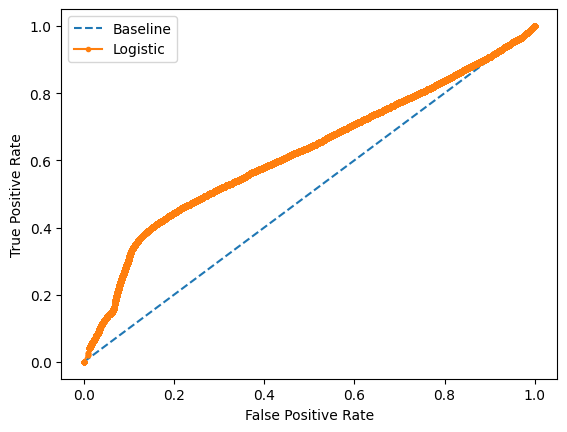

Accuracy: 0.995
Precision: 0.000
Recall: 0.000
Baseline: ROC AUC = 0.500
Logistic Regression - Default: ROC AUC = 0.621


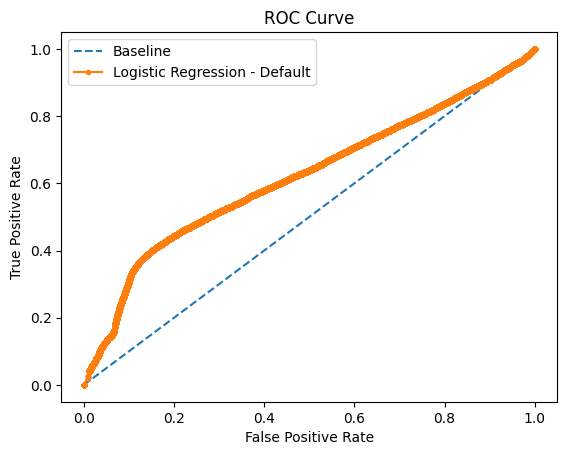

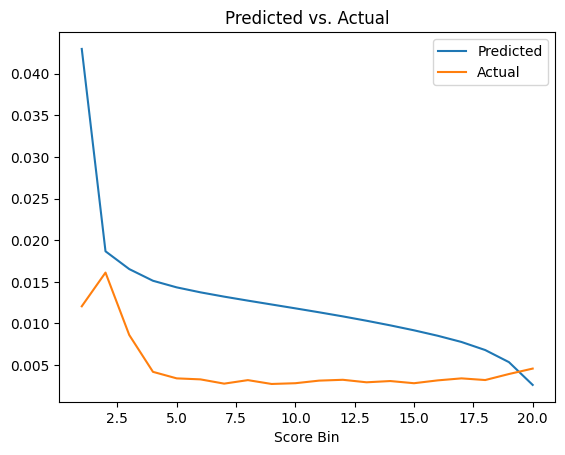

In [23]:
# 1) Logistic Regression
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
modelname="Logistic"

model.fit(X_train, y_train)

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

#evaluate_model()
#w_logit=getroc()
w_logit=evaluate_model()

predfile_logit=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'logit'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Logistic Regression - Default'

LR=model_evaluation2()

In [ ]:
# 2) Decision Tree
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier(max_depth=3, random_state=101, max_features=None, min_samples_leaf=3)
modelname='Decision Tree'

model.fit(X_train, y_train)

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_dt=evaluate_model()

predfile_dt=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'dt'})


preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Decision Tree - Default'

DT=model_evaluation2()

In [ ]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

model = DecisionTreeClassifier(max_depth=3, random_state=101, max_features=None, min_samples_leaf=3)
model = model.fit(X_train, y_train)

fig=plt.figure(figsize=(50,15))
_ =tree.plot_tree(model, 
                  feature_names=X_train.columns, 
                  class_names=['0', '1'], filled=True)

In [ ]:
# 3) Naive Bayes
from sklearn.naive_bayes import GaussianNB 
model=GaussianNB()
modelname='Naive Bayes'

model.fit(X_train, y_train)

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_nb=evaluate_model()

predfile_nb=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'nb'})


preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Naive Bayes - Default'

NB=model_evaluation2()

In [ ]:
# 4) Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

model=SGDClassifier(loss='modified_huber', shuffle=True, random_state=101)
modelname='Stochastic Gradient Descent'

model.fit(X_train, y_train)

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_sgd=evaluate_model()

predfile_sgd=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'sgd'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Stochastic Gradient Descent - Default'

SGD=model_evaluation2()

In [ ]:
# 5) KNN
from sklearn.neighbors import KNeighborsClassifier

model=KNeighborsClassifier(n_neighbors=15)
modelname='KNN'

model.fit(X_train, y_train)

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_knn=evaluate_model()

predfile_knn=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'knn'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='KNN - Default'

KNN=model_evaluation2()

In [ ]:
# 6) Light Gradient Boosting Machine
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

model=GradientBoostingClassifier()
modelname='Light Gradient Boosting'

model.fit(X_train, y_train)

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_lgb=evaluate_model()

predfile_lgb=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'lgb'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Light Gradient Descent - Default'

LGD=model_evaluation2()

In [ ]:
# 7) XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

model= XGBClassifier()
modelname='Xgboost'

model.fit(X_train,y_train)
preds=model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_xgb=evaluate_model()

predfile_xgb=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'xgb'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='XGBoost - Default'

XGB=model_evaluation2()

In [ ]:
#!pip install xgboost

In [ ]:
def roc_for_rf():
    
     # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
        # predict probabilities 
    lr_probs = model.predict_proba(X_test)
        # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
        # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
        # summarize scores
    print('Baseline: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
        # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
        # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
        # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
        # show the legend
    pyplot.legend()
        # show the plot
    pyplot.show()
    return(lr_auc)

In [ ]:
# 8) Random Forest
from sklearn.ensemble import RandomForestClassifier 

# creating a RF classifier 
model = RandomForestClassifier(n_estimators=20, random_state=20)   
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
model.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
y_pred = model.predict(X_test) 

# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

y_pred_mod=model.predict(X_train)
predfile_mod=pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_mod})

y_pred_val=model.predict(X_test)
predfile_val=pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_val})


print(predfile_mod[['Actual', 'Predicted']].mean())
print(predfile_mod[['Actual', 'Predicted']].sum())

print(predfile_val[['Actual', 'Predicted']].mean())
print(predfile_val[['Actual', 'Predicted']].sum())

matrix=confusion_matrix(predfile_mod['Actual'], predfile_mod['Predicted'], labels=[0,1])
print('Confusion matrix : \n',matrix)
pred_mod=pd.concat([failure_samp[failure_samp['seg']=='mod'], predfile_mod], join='outer', axis=1)
#matrix=confusion_matrix(pred_mod['Actual'], pred_mod['ev'], labels=[0,1])
#print('Confusion matrix : \n',matrix)


matrix=confusion_matrix(predfile_val['Actual'], predfile_val['Predicted'], labels=[0,1])
print('Confusion matrix : \n',matrix)
pred_val=pd.concat([failure_samp[failure_samp['seg']=='val'], predfile_val], join='outer', axis=1)
pred_val.head()
#matrix=confusion_matrix(pred_val['Actual'], pred_val['ev'], labels=[0,1])
#print('Confusion matrix : \n',matrix)

w_rf=roc_for_rf()

predfile_rf=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'rf'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='XGBoost - Default'

RF=model_evaluation2()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, 
                            roc_curve, auc, RocCurveDisplay, 
                            precision_recall_curve, average_precision_score)
from itertools import cycle
from sklearn.preprocessing import StandardScaler

## Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier  # Added KNN
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier

# Create synthetic dataset (imbalanced for better ROC visualization)
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    weights=[0.7, 0.3],
    random_state=42
)


# Standardize data (important for KNN and gradient-based methods)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Initialize all classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Gradient Descent (SGD)": make_pipeline(
        StandardScaler(),
        CalibratedClassifierCV(
            SGDClassifier(
                loss='log_loss',
                max_iter=1000,
                eta0=0.01,
                random_state=42
            ),
            method='sigmoid',
            cv=5
        )
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42
    ),
    "K-Nearest Neighbors": make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(
            n_neighbors=5,
            weights='distance',
            metric='minkowski',
            p=2  # Euclidean distance
        )
    ),
    "Light Gradient Boosting Machine": GradientBoostingClassifier(
    )
}

# Store performance metrics
results = []
roc_data = {}

# Plot setup
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'purple'])

# Train and evaluate each model
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        
        # Get predictions and probabilities
        y_pred = model.predict(X_test)
        
        # Handle models that don't have predict_proba (shouldn't happen with current setup)
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            # For models without predict_proba (like some SVM configurations)
            y_proba = model.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # Scale to [0,1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        avg_precision = average_precision_score(y_test, y_proba)
        
        # Store results
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'AUC': roc_auc,
            'Avg Precision': avg_precision
        })
        
        # Store ROC data
        roc_data[name] = (fpr, tpr, roc_auc)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, color=next(colors), lw=2,
                 label=f'{name} (AUC = {roc_auc:.2f})')

        # Print classification report
        print(f"\n{name} Performance:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy:.4f}, AUC: {roc_auc:.4f}, Avg Precision: {avg_precision:.4f}")
    
    except Exception as e:
        print(f"\nError with {name}: {str(e)}")
        continue

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Display results dataframe
results_df = pd.DataFrame(results).sort_values('AUC', ascending=False)
print("\nModel Comparison:")
print(results_df.to_string(index=False))

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'purple'])

for name, color in zip(roc_data.keys(), colors):
    fpr, tpr, _ = roc_data[name]
    precision, recall, _ = precision_recall_curve(y_test, models[name].predict_proba(X_test)[:, 1])
    avg_precision = average_precision_score(y_test, models[name].predict_proba(X_test)[:, 1])
    plt.plot(recall, precision, color=color, lw=2,
             label=f'{name} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Feature Importance for tree-based models
tree_based_models = {
    "Decision Tree": models["Decision Tree"],
    "Random Forest": models["Random Forest"],
    "XGBoost": models["XGBoost"],
    "Light Gradient Boosting Machine": models['Light Gradient Boosting Machine']
}

plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(tree_based_models.items(), 1):
    plt.subplot(1, 4, i)
    if name == "XGBoost":
        importances = model.feature_importances_
    else:
        importances = model.feature_importances_
    #plt.bar(range(X.shape[1]), importances)
    plt.bar(range(X.shape[1]), importances[:X.shape[1]])
    plt.title(f"{name} Feature Importance")
    plt.xlabel("Feature Index")
    plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
xgb=XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
    )

xgb.fit(X_train, y_train)

print(f"Training Accuracy: {xgb.score(X_train, y_train)}")
print(f"Test Accuracy: {xgb.score(X_test, y_test)}")
sns.barplot(x=xgb.feature_importances_, y=X_train.columns, color='blue')

In [ ]:
lgbm= GradientBoostingClassifier()

lgbm.fit(X_train, y_train)

print(f"Training Accuracy: {lgbm.score(X_train, y_train)}")
print(f"Test Accuracy: {lgbm.score(X_test, y_test)}")
sns.barplot(x=lgbm.feature_importances_, y=X_train.columns, color='blue')

In [ ]:
#sys.exit()

#### combine LGBM and XGBoost

Actual       0.013842
Predicted    0.000051
dtype: float64
Actual       13845.0
Predicted       51.0
dtype: float64
Actual       0.004633
Predicted    0.000015
dtype: float64
Actual       9227.0
Predicted      30.0
dtype: float64
Confusion matrix : 
 [[986369      3]
 [ 13797     48]]
Confusion matrix : 
 [[986372      0]
 [     0  13845]]
Confusion matrix : 
 [[1982291      30]
 [   9227       0]]
Confusion matrix : 
 [[1982321       0]
 [      0    9227]]
Baseline: ROC AUC=0.500
Light Gradient Boosting: ROC AUC=0.802


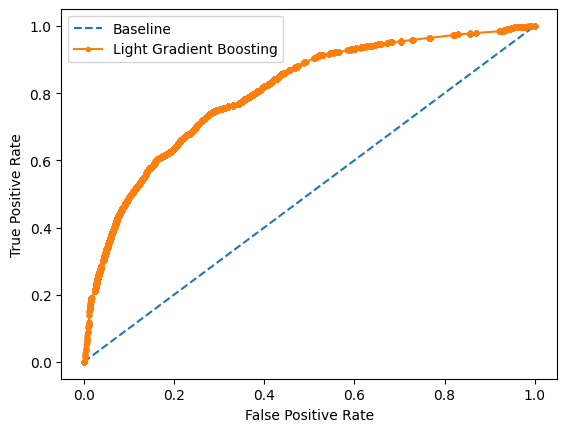

In [24]:
# 6) Light Gradient Boosting Machine
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

model=GradientBoostingClassifier()
modelname='Light Gradient Boosting'

model.fit(X_train, y_train)

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_lgb=evaluate_model()

predfile_lgb=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'lgb'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Light Gradient Descent - Default'

val_lgb=failure_samp[failure_samp['seg']=='val'][['cact']].reset_index()
val_lgb['lgb']=probs[:, 1].tolist()

#LGD=model_evaluation2()

RMSE: 0.068067
Actual       0.013842
Predicted    0.000319
dtype: float64
Actual       13845.0
Predicted      319.0
dtype: float64
Actual       0.004633
Predicted    0.000000
dtype: float64
Actual       9227.0
Predicted       0.0
dtype: float64
Confusion matrix : 
 [[986329     43]
 [ 13569    276]]
Confusion matrix : 
 [[986372      0]
 [     0  13845]]
Confusion matrix : 
 [[1982321       0]
 [   9227       0]]
Confusion matrix : 
 [[1982321       0]
 [      0    9227]]
Baseline: ROC AUC=0.500
Xgboost: ROC AUC=0.747


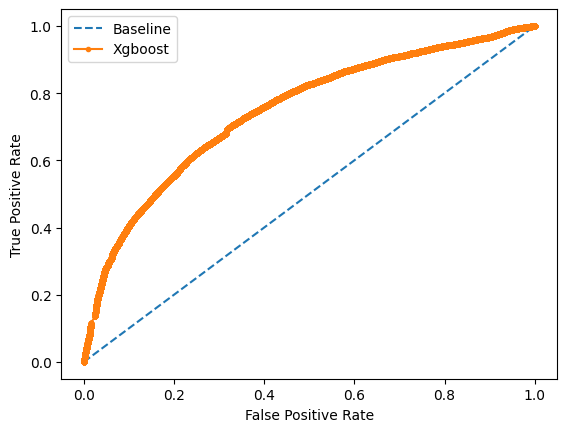

In [25]:
# 7) XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

model= XGBClassifier()
modelname='Xgboost'

model.fit(X_train,y_train)
preds=model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_xgb=evaluate_model()

predfile_xgb=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'xgb'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='XGBoost - Default'

val_xgb=failure_samp[failure_samp['seg']=='val'][['cact', 'y']].reset_index()
val_xgb['xgb']=probs[:, 1].tolist()

#XGB=model_evaluation2()

In [27]:
predfile_lgb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1991548 entries, 0 to 1991547
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   cact    float64
 1   lgb     float64
dtypes: float64(2)
memory usage: 45.6 MB


In [28]:
predfile_xgb_nodup=val_xgb.drop_duplicates(subset='cact', keep='first')
predfile_lgb_nodup=val_lgb.drop_duplicates(subset='cact', keep='first')

predfile_xgb_lgb=pd.merge(predfile_xgb_nodup, predfile_lgb_nodup, on='cact', how='inner')
predfile_xgb_lgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777473 entries, 0 to 1777472
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   index_x  int64  
 1   cact     float64
 2   y        float64
 3   xgb      float64
 4   index_y  int64  
 5   lgb      float64
dtypes: float64(4), int64(2)
memory usage: 81.4 MB


In [39]:
num_bins=20
labels=list(range(20, 0, -1))

predfile_xgb_lgb['lgb_xgb']=predfile_xgb_lgb['lgb']*predfile_xgb_lgb['xgb']*100
predfile_xgb_lgb['lgb_xgb2']=(predfile_xgb_lgb['lgb']+predfile_xgb_lgb['xgb'])/2
predfile_xgb_lgb['lgb_xgb3']=np.sqrt(predfile_xgb_lgb['lgb']*predfile_xgb_lgb['xgb'])
predfile_xgb_lgb['lgb_bin']=pd.qcut(predfile_xgb_lgb['lgb'], q=20, labels=labels)
predfile_xgb_lgb['xgb_bin']=pd.qcut(predfile_xgb_lgb['xgb'], q=20, labels=labels)
predfile_xgb_lgb['lgb_xgb_bin']=pd.qcut(predfile_xgb_lgb['lgb_xgb'], q=20, labels=labels)
predfile_xgb_lgb['lgb_xgb_bin2']=pd.qcut(predfile_xgb_lgb['lgb_xgb2'], q=20, labels=labels)
predfile_xgb_lgb['lgb_xgb_bin3']=pd.qcut(predfile_xgb_lgb['lgb_xgb3'], q=20, labels=labels)

In [40]:
bin_list=['lgb_bin',
 'xgb_bin',
 'lgb_xgb_bin',
 'lgb_xgb_bin2',
 'lgb_xgb_bin3']

for col in bin_list:
    predfile_xgb_lgb[col]=pd.to_numeric(predfile_xgb_lgb[col], errors='coerce')

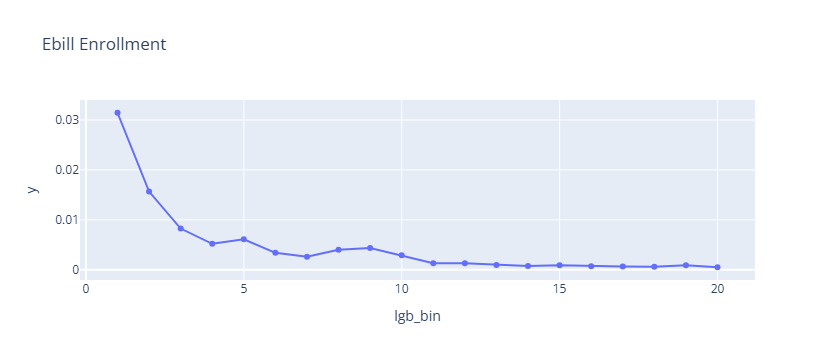

In [41]:
import plotly.express as px

predfile_xgb_lgb.groupby('lgb_bin')['y'].mean()

forline=predfile_xgb_lgb.groupby('lgb_bin')['y'].mean().reset_index()
fig = px.line(forline, x='lgb_bin', y='y', title='Ebill Enrollment', markers=True)
fig

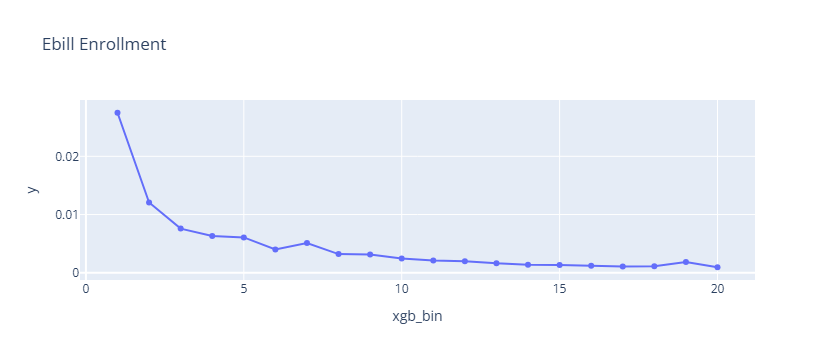

In [42]:
predfile_xgb_lgb.groupby('xgb_bin')['y'].mean()

forline=predfile_xgb_lgb.groupby('xgb_bin')['y'].mean().reset_index()
fig = px.line(forline, x='xgb_bin', y='y', title='Ebill Enrollment', markers=True)
fig

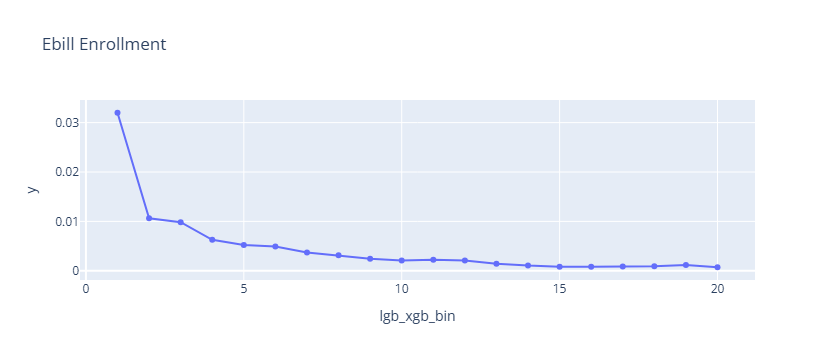

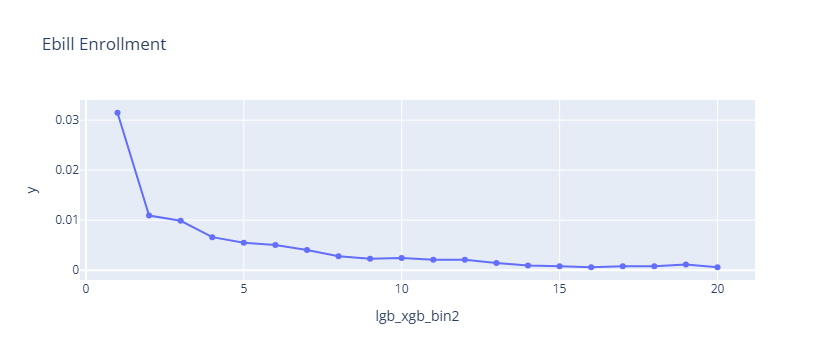

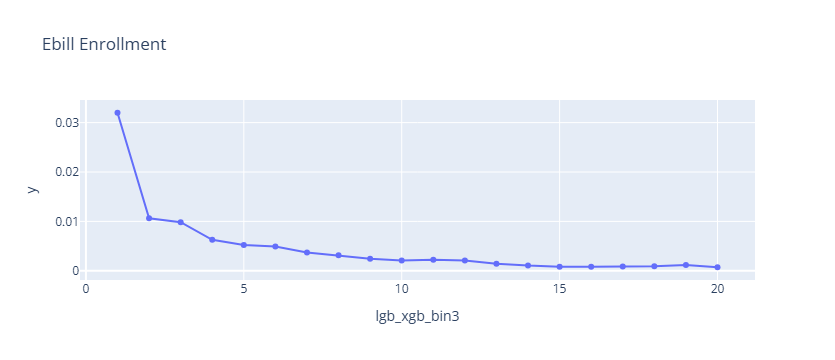

In [45]:
predfile_xgb_lgb.groupby('lgb_xgb_bin')['y'].mean()
forline=predfile_xgb_lgb.groupby('lgb_xgb_bin')['y'].mean().reset_index()
fig = px.line(forline, x='lgb_xgb_bin', y='y', title='Ebill Enrollment', markers=True)
fig.show()

predfile_xgb_lgb.groupby('lgb_xgb_bin2')['y'].mean()
forline=predfile_xgb_lgb.groupby('lgb_xgb_bin2')['y'].mean().reset_index()
fig = px.line(forline, x='lgb_xgb_bin2', y='y', title='Ebill Enrollment', markers=True)
fig.show()

predfile_xgb_lgb.groupby('lgb_xgb_bin3')['y'].mean()
forline=predfile_xgb_lgb.groupby('lgb_xgb_bin3')['y'].mean().reset_index()
fig = px.line(forline, x='lgb_xgb_bin3', y='y', title='Ebill Enrollment', markers=True)
fig.show()

In [46]:
predfile_xgb_lgb[['xgb', 'lgb', 'lgb_xgb', 'lgb_xgb2', 'lgb_xgb3']].corr()

,xgb,lgb,lgb_xgb,lgb_xgb2,lgb_xgb3
xgb,1.000000,0.707604,0.820244,0.930646,0.918911
lgb,0.707604,1.000000,0.827633,0.917092,0.895338
lgb_xgb,0.820244,0.827633,1.000000,0.891383,0.916381
lgb_xgb2,0.930646,0.917092,0.891383,1.000000,0.982114
lgb_xgb3,0.918911,0.895338,0.916381,0.982114,1.000000


In [47]:
# extract new enroll since 2025/08/11
# notice we use 2025-02-01 as the cutoff data for enrollment
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

    SELECT 
            ZOBJTID as cact,
            max(to_date(ZUDATE___T))    as last_enroll_date,
            min(days_between(to_date(ZUDATE___T), cutoff_date)) as last_enroll_recency, 
            count(case when days_between(to_date(ZUDATE___T), cutoff_date) < 365 then 1 else 0 end) as enroll_cnt_lastyear,
            count(case when days_between(to_date(ZUDATE___T), cutoff_date) < 730 then 1 else 0 end) as enroll_cnt_last2years 
        FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"
            WHERE ZVALUENEW = 'EBIL'
            and to_date(ZUDATE___T) > cutoff_date
        group by ZOBJTID;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 
    
new_enroll=pd.DataFrame(ret)
new_enroll.columns=['cact', 'past_enroll_date', 'past_enroll_recency', 'enroll_cnt_lastyear', 'enroll_cnt_last2years']
new_enroll.info()
new_enroll.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59141 entries, 0 to 59140
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cact                   59141 non-null  object
 1   past_enroll_date       59141 non-null  object
 2   past_enroll_recency    59141 non-null  int64 
 3   enroll_cnt_lastyear    59141 non-null  int64 
 4   enroll_cnt_last2years  59141 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.3+ MB


,cact,past_enroll_date,past_enroll_recency,enroll_cnt_lastyear,enroll_cnt_last2years
0,600001002847,2025-09-03,-23,2,2
1,700001346021,2025-08-12,-1,1,1
2,700001598423,2025-08-12,-1,1,1
3,700001632775,2025-08-12,-1,1,1
4,700001796059,2025-08-12,-1,1,1


In [48]:
new_enroll['cact']=pd.to_numeric(new_enroll['cact'], errors='coerce')
new_enroll.drop_duplicates(subset='cact', keep='first', inplace=True)

In [49]:
pred_file_val=pd.merge(predfile_xgb_lgb, new_enroll.assign(y2=1), on='cact', how='left')
pred_file_val['y2'].fillna(0, inplace=True)

/var/tmp/ipykernel_26045/1830359806.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





    lgb_xgb_bin        y2
0             1  0.066353
1             2  0.031291
2             3  0.026982
3             4  0.023066
4             5  0.022977
5             6  0.020061
6             7  0.016349
7             8  0.016934
8             9  0.014774
9            10  0.015055
10           11  0.013491
11           12  0.010306
12           13  0.006762
13           14  0.004411
14           15  0.003557
15           16  0.002913
16           17  0.003319
17           18  0.003716
18           19  0.006612
19           20  0.003668


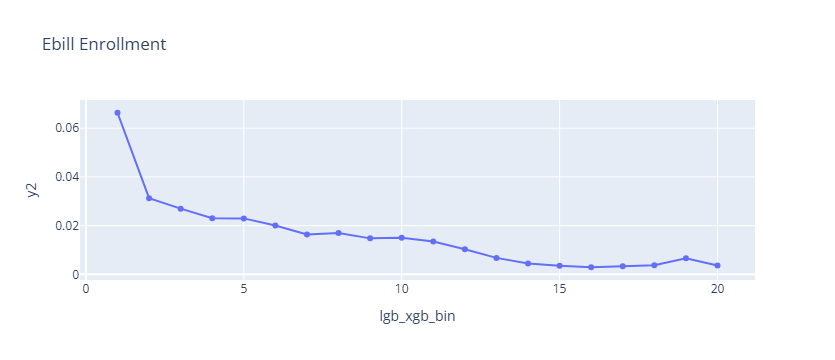

    lgb_xgb_bin2        y2
0              1  0.065306
1              2  0.031988
2              3  0.028640
3              4  0.024023
4              5  0.022121
5              6  0.020679
6              7  0.016713
7              8  0.015462
8              9  0.013580
9             10  0.016053
10            11  0.014363
11            12  0.010644
12            13  0.007356
13            14  0.004283
14            15  0.003175
15            16  0.002451
16            17  0.003027
17            18  0.002948
18            19  0.006761
19            20  0.003202


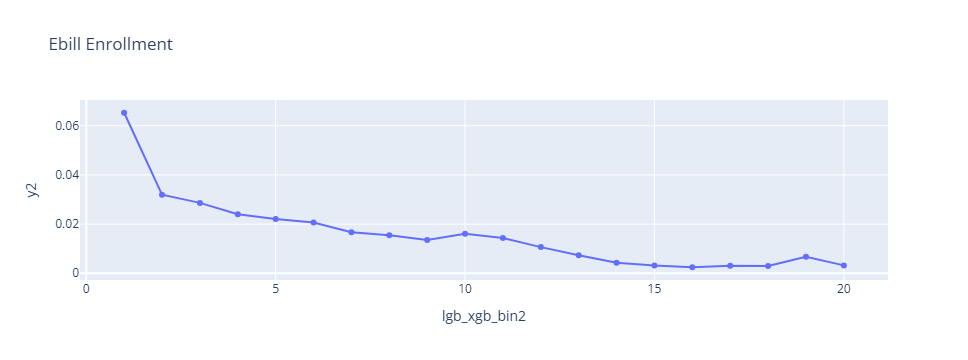

    lgb_xgb_bin3        y2
0              1  0.066353
1              2  0.031291
2              3  0.026982
3              4  0.023066
4              5  0.022977
5              6  0.020061
6              7  0.016349
7              8  0.016934
8              9  0.014774
9             10  0.015055
10            11  0.013491
11            12  0.010306
12            13  0.006762
13            14  0.004411
14            15  0.003557
15            16  0.002913
16            17  0.003319
17            18  0.003716
18            19  0.006612
19            20  0.003668


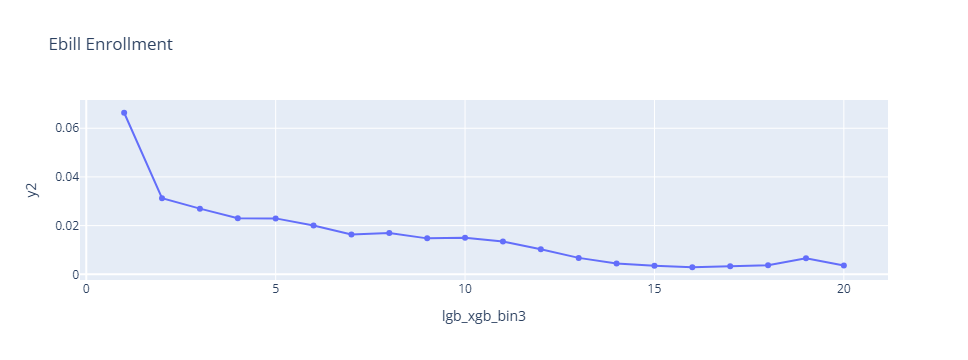

In [51]:
pred_file_val.groupby('lgb_xgb_bin')['y2'].mean()
forline=pred_file_val.groupby('lgb_xgb_bin')['y2'].mean().reset_index()
print(forline)
fig = px.line(forline, x='lgb_xgb_bin', y='y2', title='Ebill Enrollment', markers=True)
fig.show()

pred_file_val.groupby('lgb_xgb_bin2')['y2'].mean()
forline=pred_file_val.groupby('lgb_xgb_bin2')['y2'].mean().reset_index()
print(forline)
fig = px.line(forline, x='lgb_xgb_bin2', y='y2', title='Ebill Enrollment', markers=True)
fig.show()

pred_file_val.groupby('lgb_xgb_bin3')['y2'].mean()
forline=pred_file_val.groupby('lgb_xgb_bin3')['y2'].mean().reset_index()
print(forline)
fig = px.line(forline, x='lgb_xgb_bin3', y='y2', title='Ebill Enrollment', markers=True)
fig.show()


In [ ]:
pred_file_val.to_csv('gs://ebill_enrollment_model/input_20250811/val_y_20250811.csv', index=False)